7/7 [==============================] - 6s 853ms/step
Bagging Classifier Training accuracy: 1.0
Bagging Classifier Testing accuracy: 0.8293838862559242
Precision: 0.8283065712415169
Recall: 0.8293838862559242
F1-score: 0.8178591200265841
                     precision    recall  f1-score   support

     European beech       0.93      1.00      0.97        43
European silver fir       0.80      0.49      0.61        49
      Norway spruce       0.77      0.91      0.84        67
        Sessile oak       0.84      0.90      0.87        52

           accuracy                           0.83       211
          macro avg       0.84      0.83      0.82       211
       weighted avg       0.83      0.83      0.82       211



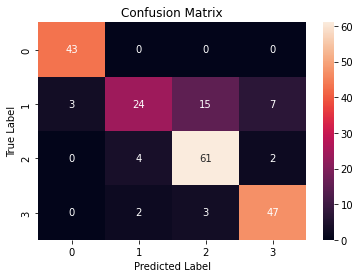

In [4]:
import cv2 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Directories for training and testing datasets
train_dir = "D:/Gokul/segall_new_exact/Train"
test_dir = "D:/Gokul/segall_new_exact/Test"

# Initialize lists for features and labels
features_cnn_train = []
labels_train = []
features_cnn_test = []
labels_test = []

# Helper function to process images
def process_images(directory, features, labels):
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (350, 350))
            img_cnn = img_to_array(img)
            features.append(img_cnn)
            labels.append(category)

# Process training and testing datasets
process_images(train_dir, features_cnn_train, labels_train)
process_images(test_dir, features_cnn_test, labels_test)

# Convert features and labels to numpy arrays
features_cnn_train = np.array(features_cnn_train)
labels_train = np.array(labels_train)
features_cnn_test = np.array(features_cnn_test)
labels_test = np.array(labels_test)

# Create CNN model for feature extraction
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(350, 350, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(512, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())

# Extract CNN features for training and testing datasets
features_cnn_train = model_cnn.predict(features_cnn_train)
features_cnn_test = model_cnn.predict(features_cnn_test)

# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define base classifier
dt_clf = DecisionTreeClassifier(random_state=0)

# Train Bagging Classifier
bagging_clf = BaggingClassifier(dt_clf, n_estimators=380, max_samples=0.9, max_features=0.9)
bagging_clf.fit(features_cnn_train, labels_train)

# Evaluate the model
bagging_pred = bagging_clf.predict(features_cnn_test)
bagging_accuracy = accuracy_score(labels_test, bagging_pred)

print('Bagging Classifier Training accuracy:', bagging_clf.score(features_cnn_train, labels_train))
print('Bagging Classifier Testing accuracy:', bagging_accuracy)

# Additional Metrics
precision = precision_score(labels_test, bagging_pred, average='weighted')
recall = recall_score(labels_test, bagging_pred, average='weighted')
f1 = f1_score(labels_test, bagging_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Confusion Matrix and Classification Report
print(classification_report(labels_test, bagging_pred))
matrix = confusion_matrix(labels_test, bagging_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
